<center><h1>Thai_Khang_HW5</h1></center>
<br>
<br>

Name: Khang Thai
<br>
Github Username: kunfupen
<br>
USC ID: 5721113147

## 1. Decision Trees as Interpretable Models

Import packages

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

### (a) Obtain Data

Get the Accute Inamations Data Set

In [13]:
data_path = Path(r"C:\Users\kunfu\OneDrive\Documents\GitHub\DSCI-552\Homework\Homework 5 Data\diagnosis.data")
data = pd.read_csv(data_path, sep='\t', header=None, encoding='utf-16')
data.columns = ['Temperature', 'Nausea', 'Lumbar Pain', 'Urine Pushing', 
                'Micturition Pains', 'Buring Urethra', 'Bladder Inflammation', 'Nephritis Pelvis']
print(data.head())
data.info()

  Temperature Nausea Lumbar Pain Urine Pushing Micturition Pains  \
0        35,5     no         yes            no                no   
1        35,9     no          no           yes               yes   
2        35,9     no         yes            no                no   
3        36,0     no          no           yes               yes   
4        36,0     no         yes            no                no   

  Buring Urethra Bladder Inflammation Nephritis Pelvis  
0             no                   no               no  
1            yes                  yes               no  
2             no                   no               no  
3            yes                  yes               no  
4             no                   no               no  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Temperature           120 non-null    ob

### (b) Build a decision tree

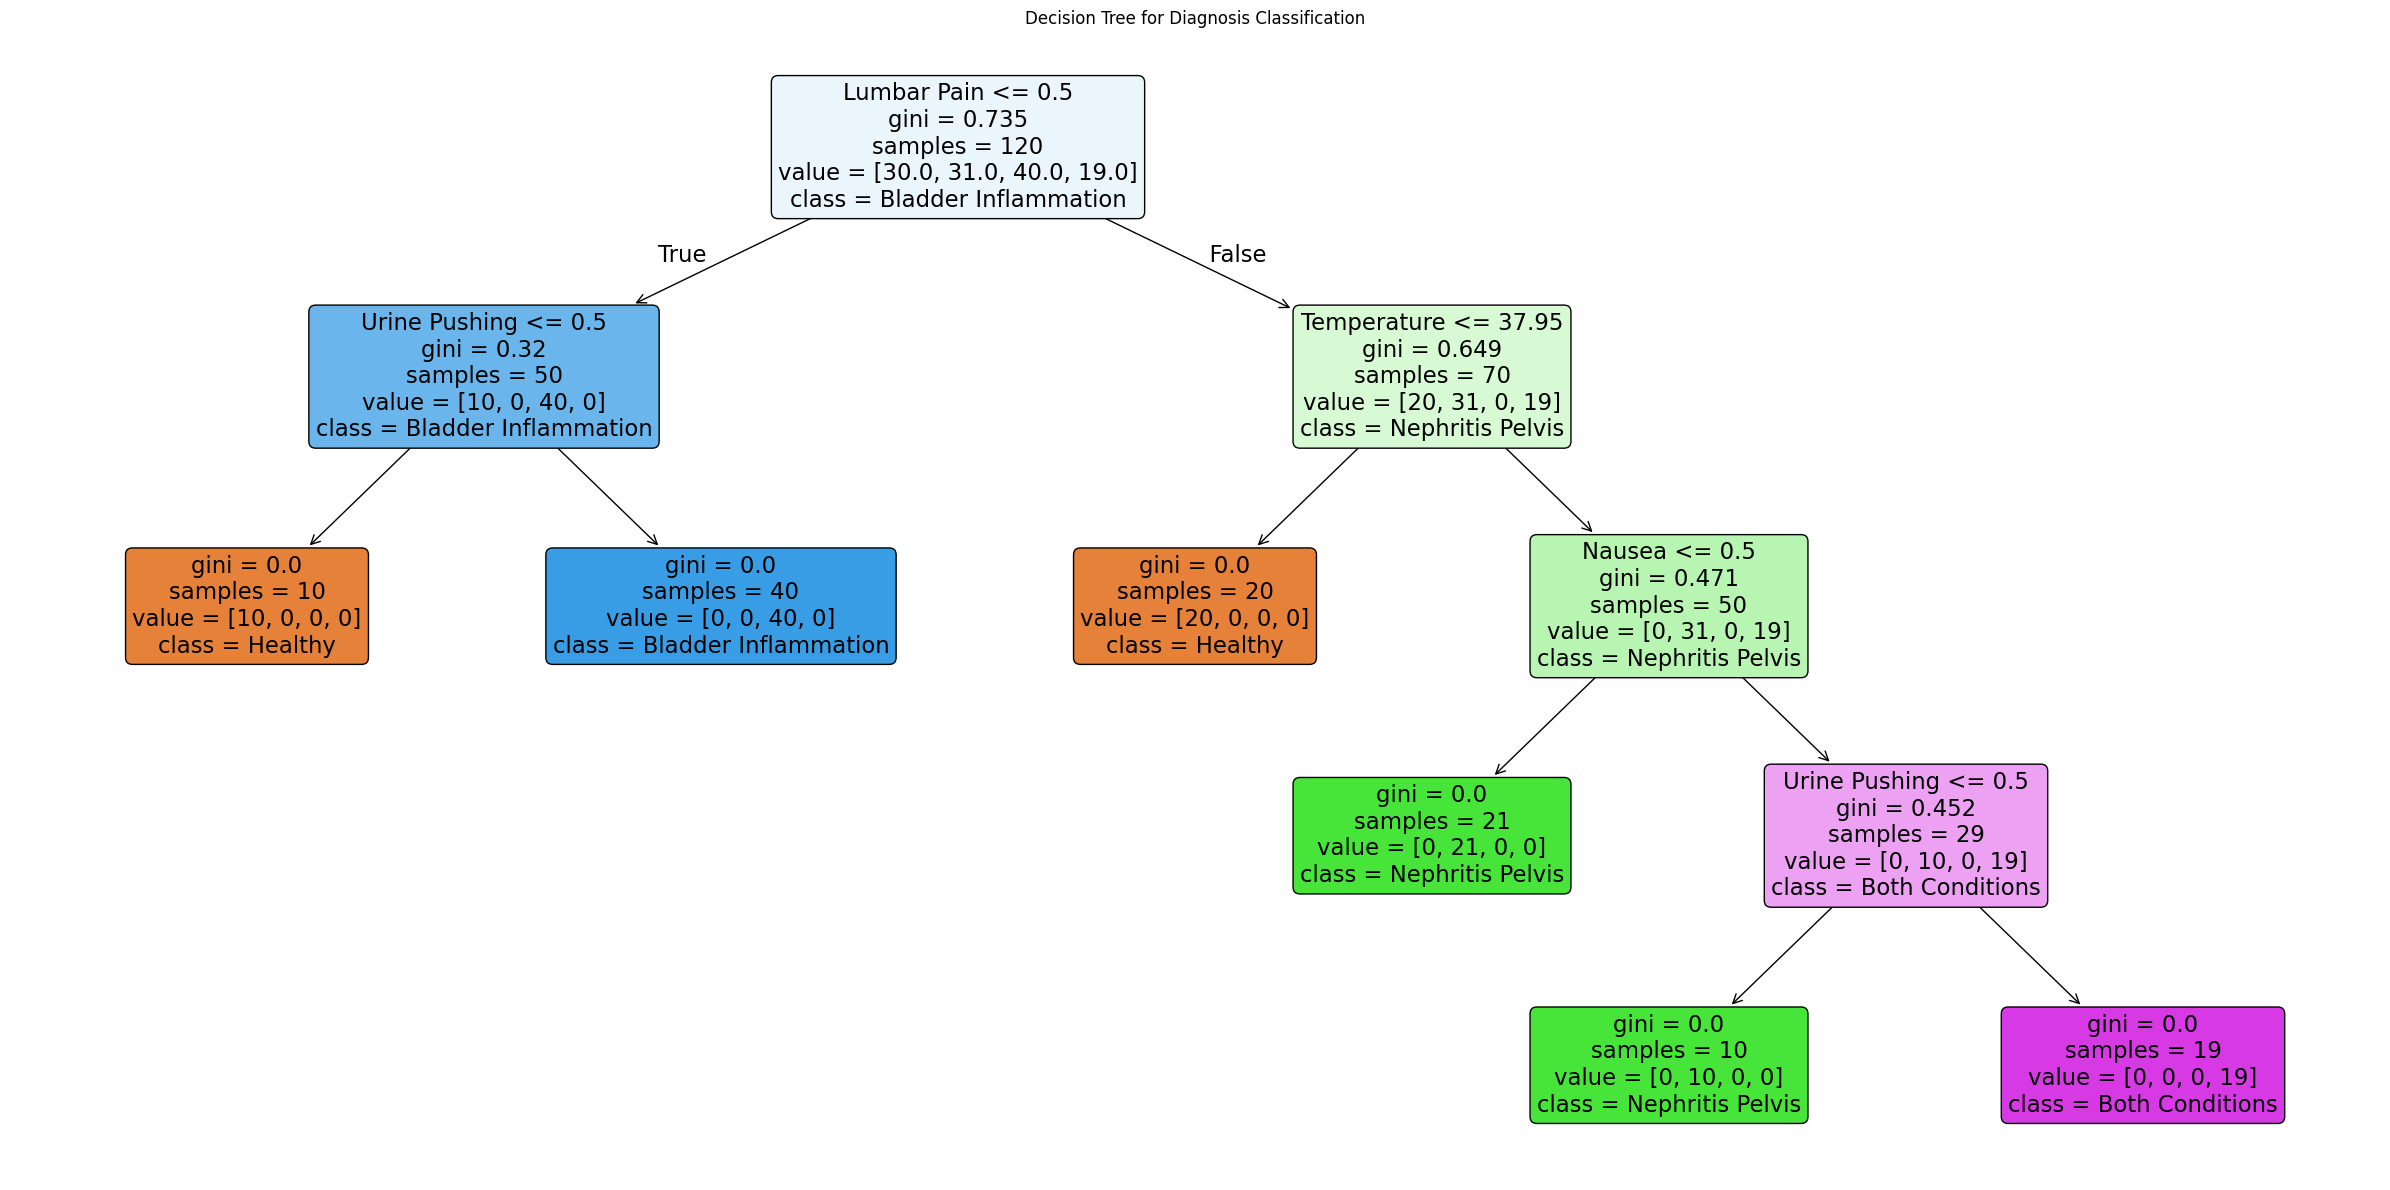

In [14]:
x = data.iloc[:, :6].copy()
y = data.iloc[:, 6:].copy()

x.columns = ['Temperature', 'Nausea', 'Lumbar Pain', 'Urine Pushing', 
                'Micturition Pains', 'Buring Urethra']
y.columns = ['Bladder Inflammation', 'Nephritis Pelvis']

x['Temperature'] = x['Temperature'].str.replace(',', '.').astype(float)

for col in x.columns[1:]:
    x[col] = x[col].map({'yes': 1, 'no': 0})

for col in y.columns:
    y[col] = y[col].map({'yes': 1, 'no': 0})

y_combined = y['Bladder Inflammation'].astype(str) + '_' + y['Nephritis Pelvis'].astype(str)

label_mapping = {
    '0_0': 'Healthy',
    '0_1': 'Nephritis Pelvis',
    '1_0': 'Bladder Inflammation',
    '1_1': 'Both Conditions'
}

for label in sorted(y_combined.unique()):
    count = (y_combined == label).sum()

decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(x, y_combined)

plt.figure(figsize=(24, 12))
class_names = [label_mapping[label] for label in sorted(y_combined.unique())]
plot_tree(decision_tree, feature_names=x.columns.tolist(), class_names=class_names, filled=True, rounded=True)
plt.title("Decision Tree for Diagnosis Classification")
plt.tight_layout()
plt.show()

### (c) Convert the decision rules

In [15]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = " " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))
    recurse(0, 1)

tree_to_code(decision_tree, x.columns.tolist())


def tree(Temperature, Nausea, Lumbar Pain, Urine Pushing, Micturition Pains, Buring Urethra):
 if Lumbar Pain <= 0.5:
  if Urine Pushing <= 0.5:
   return [[1. 0. 0. 0.]]
  else:  # if Urine Pushing > 0.5
   return [[0. 0. 1. 0.]]
 else:  # if Lumbar Pain > 0.5
  if Temperature <= 37.95000076293945:
   return [[1. 0. 0. 0.]]
  else:  # if Temperature > 37.95000076293945
   if Nausea <= 0.5:
    return [[0. 1. 0. 0.]]
   else:  # if Nausea > 0.5
    if Urine Pushing <= 0.5:
     return [[0. 1. 0. 0.]]
    else:  # if Urine Pushing > 0.5
     return [[0. 0. 0. 1.]]


### (d) Cost-complexity pruning

In [16]:
path = decision_tree.cost_complexity_pruning_path(x, y_combined)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

trees = []
train_scores = []
scores = []
tree_depths = []
tree_leaves = []

for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    tree.fit(x, y_combined)
    train_score = tree.score(x, y_combined)
    score = cross_val_score(tree, x, y_combined, cv=5)
    trees.append(tree)
    train_scores.append(train_score)
    scores.append(score)
    tree_depths.append(tree.get_depth())
    tree_leaves.append(tree.get_n_leaves())

best_idx = np.argmax(scores)
best_alpha = ccp_alphas[best_idx]
best_score = scores[best_idx]

pruned_tree = trees[best_idx]

def tree_to_code_pruned(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def pruned_tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = " " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))
    recurse(0, 1)

tree_to_code_pruned(pruned_tree, x.columns.tolist())

def pruned_tree(Temperature, Nausea, Lumbar Pain, Urine Pushing, Micturition Pains, Buring Urethra):
 if Lumbar Pain <= 0.5:
  if Urine Pushing <= 0.5:
   return [[1. 0. 0. 0.]]
  else:  # if Urine Pushing > 0.5
   return [[0. 0. 1. 0.]]
 else:  # if Lumbar Pain > 0.5
  if Temperature <= 37.95000076293945:
   return [[1. 0. 0. 0.]]
  else:  # if Temperature > 37.95000076293945
   return [[0.   0.62 0.   0.38]]


## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [17]:
data_path = Path(r"C:\Users\kunfu\OneDrive\Documents\GitHub\DSCI-552\Homework\Homework 5 Data\communities.data")
data = pd.read_csv(data_path, header=None, na_values='?')

train_data = data.iloc[:1495].copy()
test_data = data.iloc[1495:].copy()

### (b) Missing values

In [18]:
train_data = train_data.iloc[:, 5:].copy()
test_data = test_data.iloc[:, 5:].copy()

x_train =train_data.iloc[:, :-1].copy()
y_train = train_data.iloc[:, -1].copy()
x_test = test_data.iloc[:, :-1].copy()
y_test = test_data.iloc[:, -1].copy()

train_missing = x_train.isnull().sum().sum()
test_missing = x_test.isnull().sum().sum()
print(f"missing values training set: {train_missing:,} ({train_missing / (x_train.shape[0] * x_train.shape[1]):.2%})")
print(f"missing values test set: {test_missing:,} ({test_missing / (x_test.shape[0] * x_test.shape[1]):.2%})")

imputer = SimpleImputer(strategy='median')
x_train_imputed = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns, index=x_test.index)

print(f"training set after imputation: {x_train_imputed.isnull().sum().sum()}")
print(f"test set after imputation: {x_test_imputed.isnull().sum().sum()}")

missing values training set: 27,633 (15.15%)
missing values test set: 9,218 (15.14%)
training set after imputation: 0
test set after imputation: 0


### (c) Plot a correlation matrix

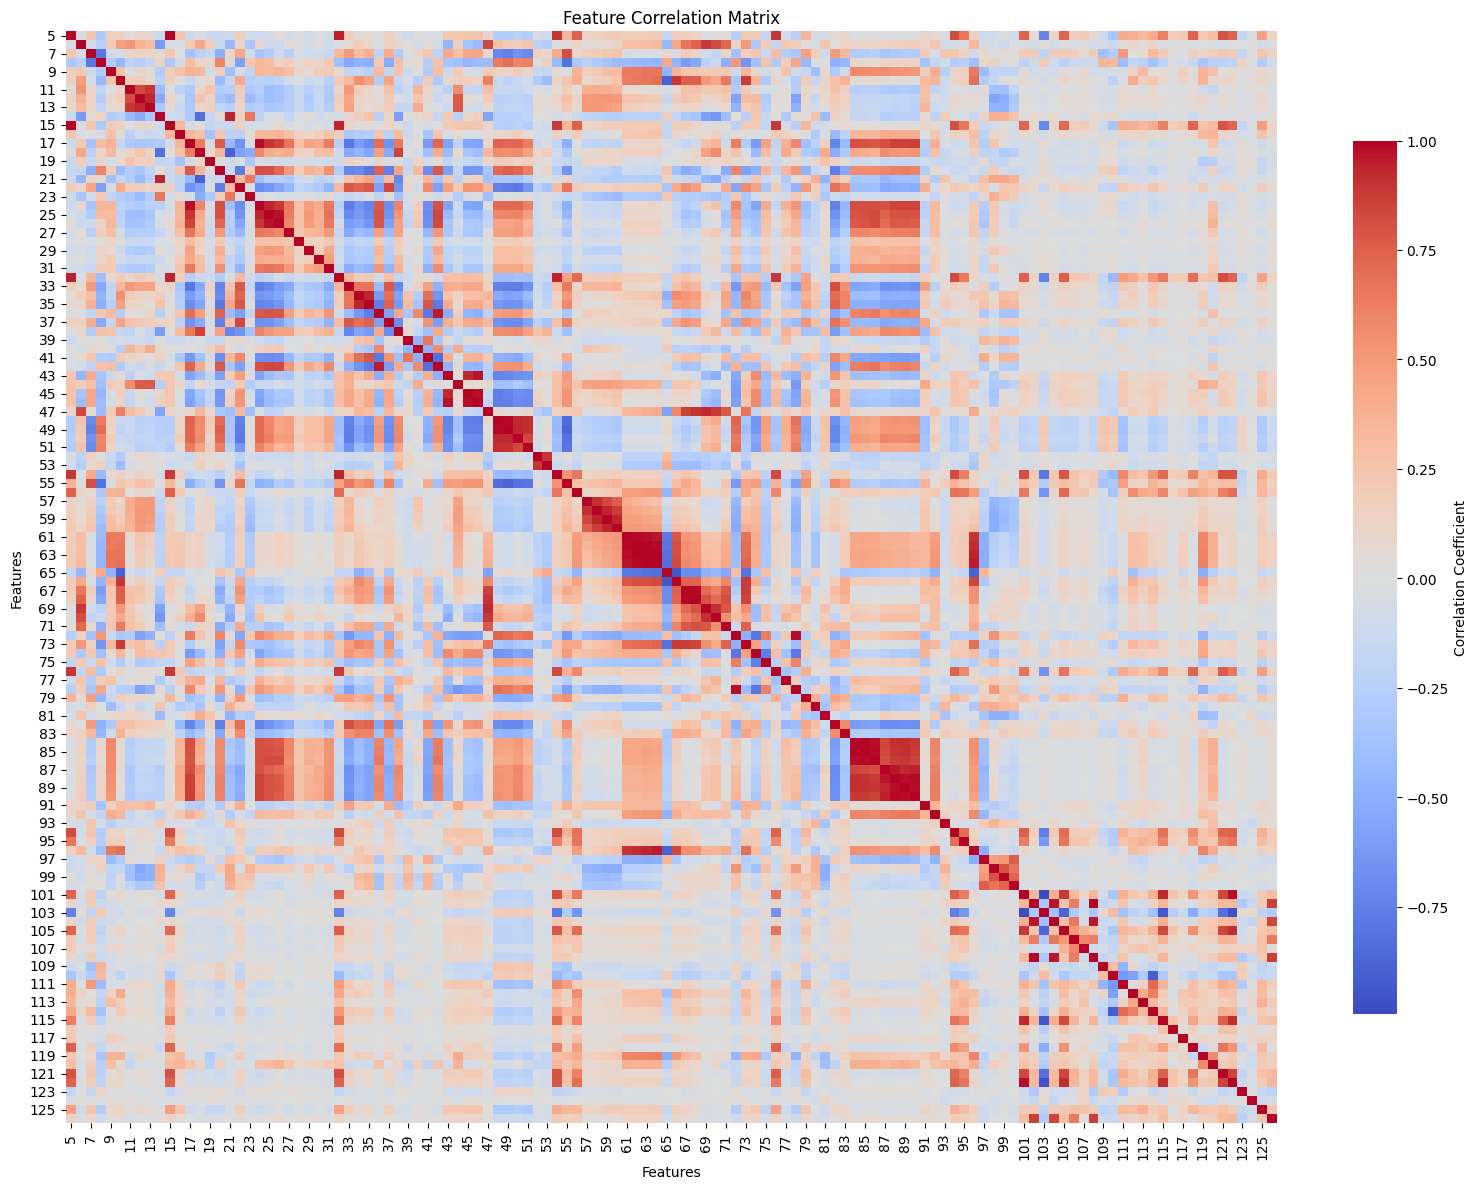

In [19]:
corr_matrix = x_train_imputed.corr()

corr_val = corr_matrix.values[np.triu_indices_from(corr_matrix, k=1)]

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, cbar_kws={"shrink": .8, "label": "Correlation Coefficient"})
plt.title("Feature Correlation Matrix")
plt.xlabel("Features")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [20]:
means = x_train_imputed.mean()
stds = x_train_imputed.std()

cv_val = stds / means.replace(0, np.nan)

cv_df = pd.DataFrame({
    'Feature': x_train_imputed.columns,
    'Mean': means.values,
    'Standard Deviation': stds.values,
    'CV': cv_val.values
}).sort_values(by='CV', ascending=False)

print(len(cv_df))
print(cv_df.head(10))

122
     Feature      Mean  Standard Deviation        CV
108      113  0.016254            0.089838  5.527059
90        95  0.022983            0.098665  4.292923
89        94  0.029599            0.102736  3.470952
49        54  0.037204            0.113806  3.058964
51        56  0.030595            0.089541  2.926635
120      125  0.093304            0.238201  2.552946
27        32  0.056849            0.133167  2.342443
96       101  0.028749            0.064629  2.248042
0          5  0.058167            0.130359  2.241105
10        15  0.064649            0.131784  2.038461


### (e) Scatter plots and box plots for highest CV features

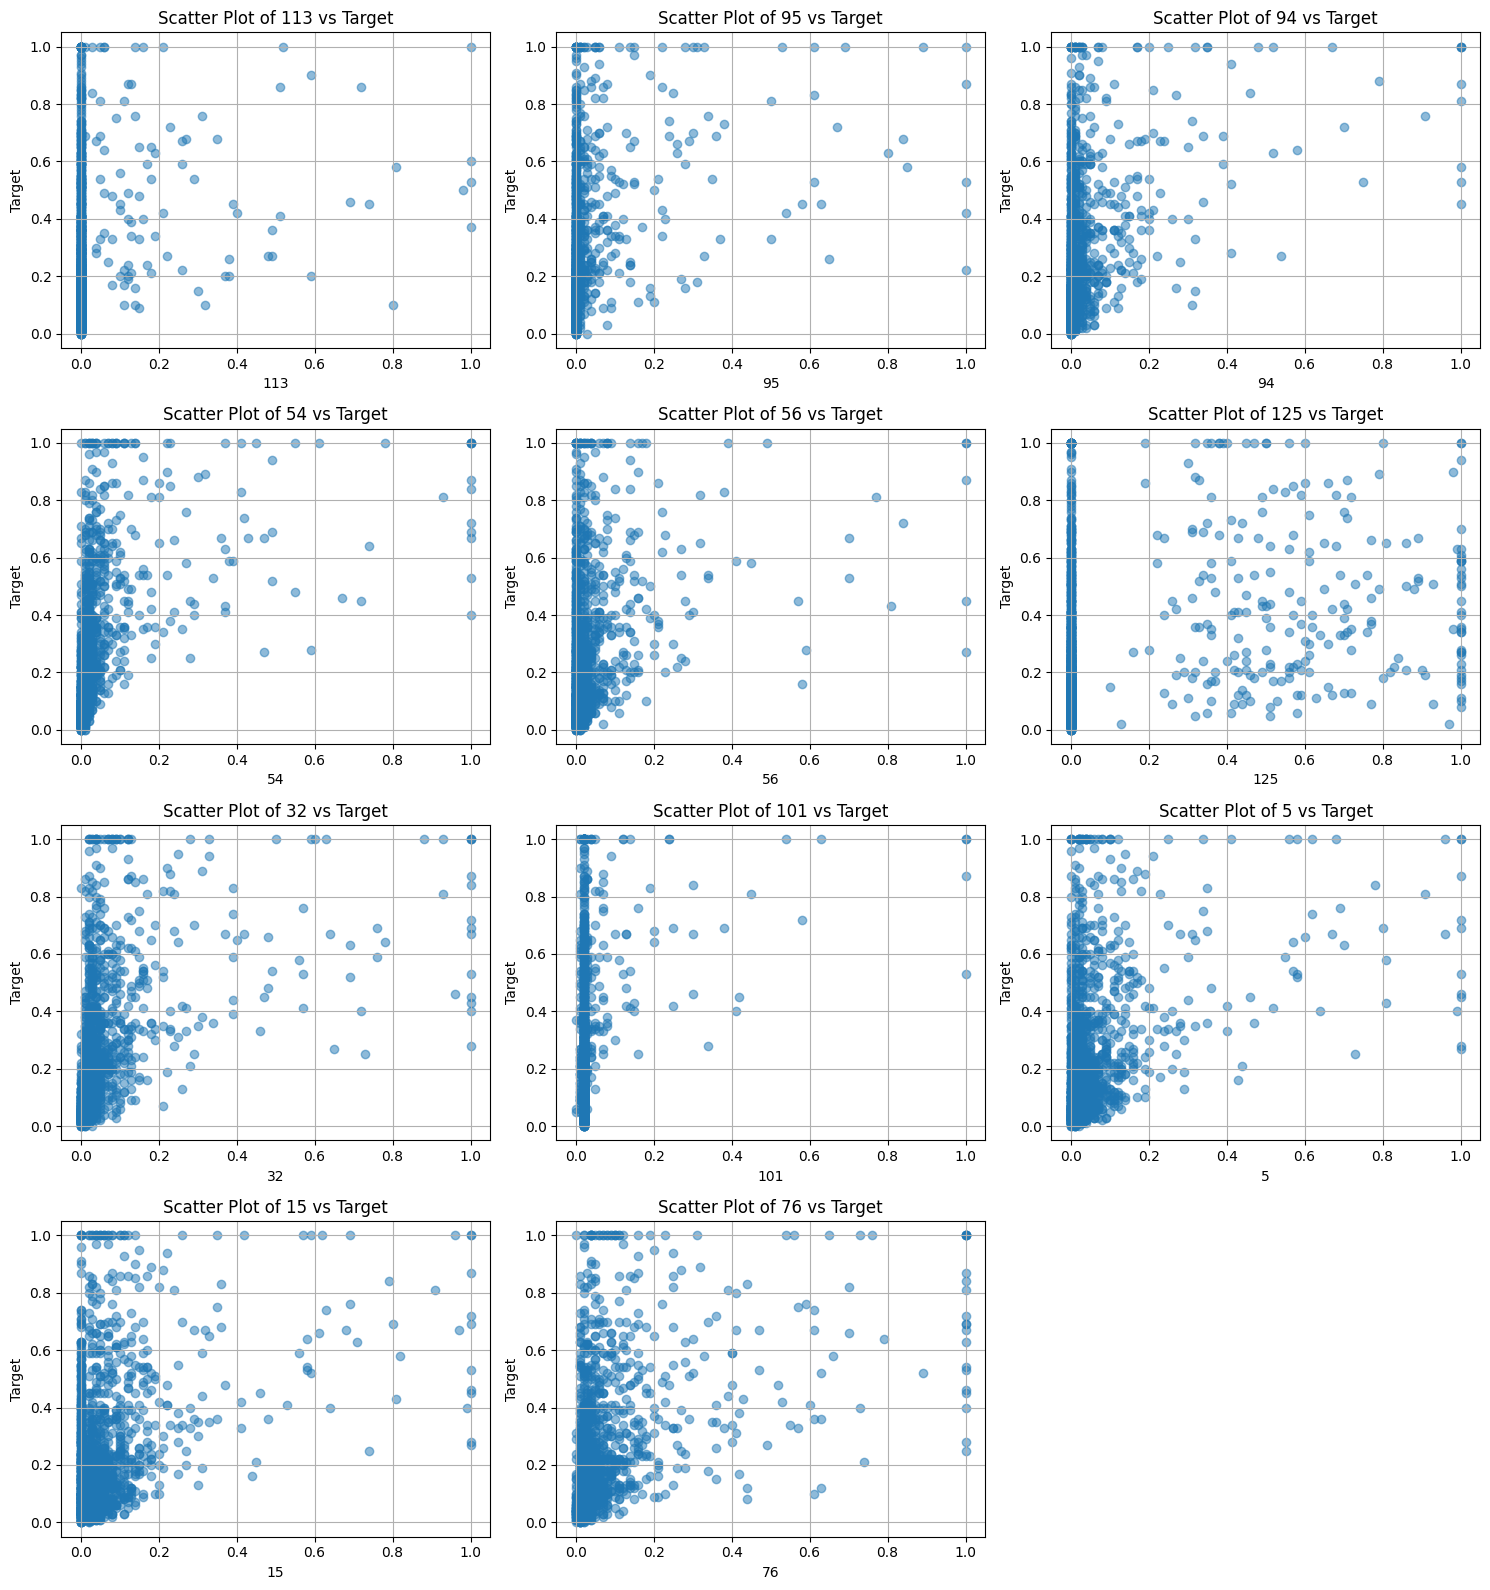

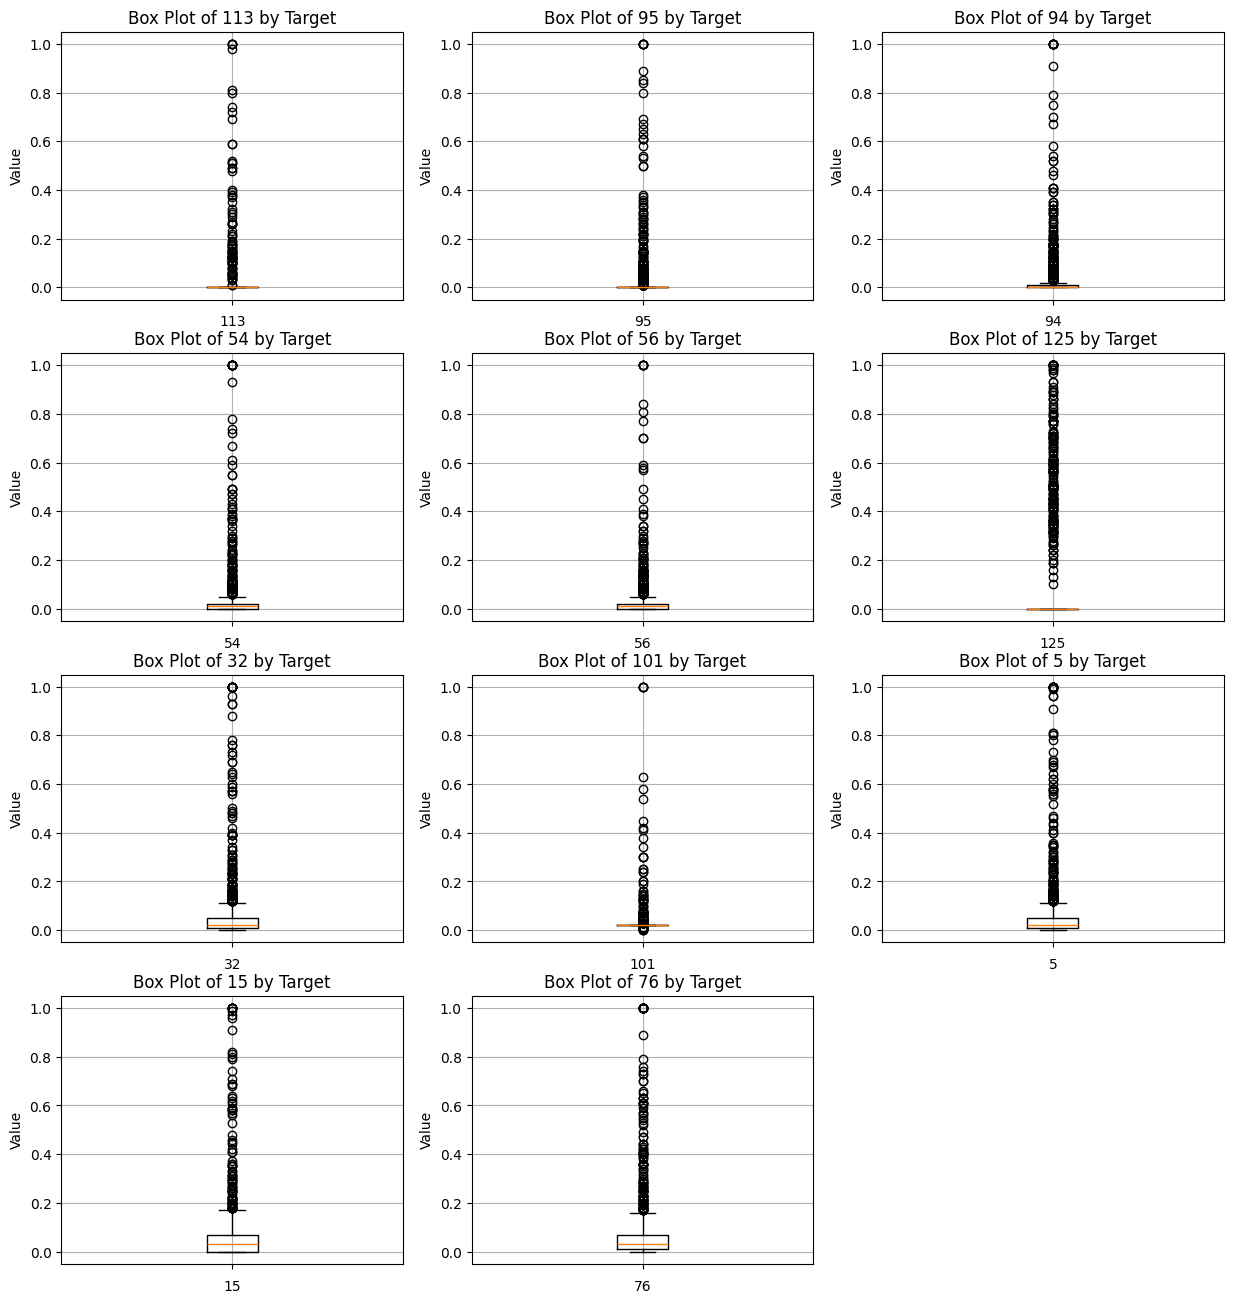

In [21]:
n_feat = int(np.sqrt(128))

selected_features = cv_df.head(n_feat)['Feature'].values

n_cols = 3
n_rows = int(np.ceil(n_feat / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    axes[i].scatter(x_train_imputed[feature], y_train, alpha=0.5)
    axes[i].set_title(f'Scatter Plot of {feature} vs Target')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Target')
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    axes[i].boxplot(x_train_imputed[feature])
    axes[i].set_title(f'Box Plot of {feature} by Target')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Value')
    axes[i].set_xticklabels([''])
    axes[i].grid(True)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


### (f) Fit a linear model

In [22]:
model = LinearRegression()
model.fit(x_train_imputed, y_train)

y_train_pred = model.predict(x_train_imputed)
y_test_pred = model.predict(x_test_imputed)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Training Set: MSE = {mse_train:.4}, RMSE = {rmse_train:.4f}, R² = {r2_train:.4f}, MAE = {mae_train:.4f}")
print(f"Test Set: MSE = {mse_test:.4}, RMSE = {rmse_test:.4f}, R² = {r2_test:.4f}, MAE = {mae_test:.4f}")


Training Set: MSE = 0.01629, RMSE = 0.1276, R² = 0.7115, MAE = 0.0901
Test Set: MSE = 0.01797, RMSE = 0.1340, R² = 0.6222, MAE = 0.0963


### (g) Fit a ridge regression model

In [23]:
alpha = np.logspace(-3, 3, 100)

ridge = RidgeCV(alphas=alpha, cv=5, scoring='neg_mean_squared_error')
ridge.fit(x_train_imputed, y_train)

optimal_alpha = ridge.alpha_

y_train_pred_ridge = ridge.predict(x_train_imputed)
y_test_pred_ridge = ridge.predict(x_test_imputed)

mse_train_ridge = mean_squared_error(y_train, y_train_pred_ridge)
mse_test_ridge = mean_squared_error(y_test, y_test_pred_ridge)
rmse_train_ridge = np.sqrt(mse_train_ridge)
rmse_test_ridge = np.sqrt(mse_test_ridge)
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)

print(f"Optimal alpha: {optimal_alpha:.4f}")
print(f"Ridge Regression Training Set: MSE = {mse_train_ridge:.4}, RMSE = {rmse_train_ridge:.4f}, R² = {train_r2_ridge:.4f}")
print(f"Ridge Regression Test Set: MSE = {mse_test_ridge:.4}, RMSE = {rmse_test_ridge:.4f}, R² = {test_r2_ridge:.4f}")


Optimal alpha: 2.4771
Ridge Regression Training Set: MSE = 0.01701, RMSE = 0.1304, R² = 0.6988
Ridge Regression Test Set: MSE = 0.01751, RMSE = 0.1323, R² = 0.6318


### (h) Fit a LASSO model

In [24]:
alphas = np.logspace(-4, 0, 100)

lasso = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=10000)
lasso.fit(x_train_imputed, y_train)

optimal_alpha_lasso = lasso.alpha_

y_train_pred_lasso = lasso.predict(x_train_imputed)
y_test_pred_lasso = lasso.predict(x_test_imputed)

mse_train_lasso = mean_squared_error(y_train, y_train_pred_lasso)
mse_test_lasso = mean_squared_error(y_test, y_test_pred_lasso)
rmse_train_lasso = np.sqrt(mse_train_lasso) 
rmse_test_lasso = np.sqrt(mse_test_lasso)
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

non_zero_coefs = np.sum(lasso.coef_ != 0)
selected_features_lasso = x_train_imputed.columns[lasso.coef_ != 0].tolist()

print(f"Optimal alpha for Lasso: {optimal_alpha_lasso:.4f}")
print(f"Lasso Regression Training Set: MSE = {mse_train_lasso:.4}, RMSE = {rmse_train_lasso:.4f}, R² = {r2_train_lasso:.4f}")
print(f"Lasso Regression Test Set: MSE = {mse_test_lasso:.4}, RMSE = {rmse_test_lasso:.4f}, R² = {r2_test_lasso:.4f}")
print(f"Number of selected features by Lasso: {non_zero_coefs}")
print()

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_imputed)
x_test_scaled = scaler.transform(x_test_imputed)

x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_train_imputed.columns, index=x_train_imputed.index)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_test_imputed.columns, index=x_test_imputed.index)

alphas = np.logspace(-4, 0, 100)

lasso_std = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=10000)
lasso_std.fit(x_train_scaled_df, y_train)

optimal_lambda_lasso_std = lasso_std.alpha_
print(f"Optimal alpha for Lasso: {optimal_lambda_lasso_std:.4f}")

y_test_pred_lasso = lasso_std.predict(x_test_scaled_df)

mse_test_std = mean_squared_error(y_test, y_test_pred_lasso)
rmse_test_std = np.sqrt(mse_test_std)
r2_test_std = r2_score(y_test, y_test_pred_lasso)

selected_features_lasso_std = x_train_scaled_df.columns[lasso_std.coef_ != 0].tolist()
num_selected_features_lasso_std = len(selected_features_lasso_std)

print(f"Lasso Regression with Standardization Test Set: MSE = {mse_test_std:.4}, RMSE = {rmse_test_std:.4f}, R² = {r2_test_std:.4f}")
print(f"Number of selected features: {num_selected_features_lasso_std}")
print()
print("Both models perform very similar to one another.")

Optimal alpha for Lasso: 0.0001
Lasso Regression Training Set: MSE = 0.01705, RMSE = 0.1306, R² = 0.6980
Lasso Regression Test Set: MSE = 0.01761, RMSE = 0.1327, R² = 0.6298
Number of selected features by Lasso: 75

Optimal alpha for Lasso: 0.0008
Lasso Regression with Standardization Test Set: MSE = 0.01768, RMSE = 0.1330, R² = 0.6282
Number of selected features: 72

Both models perform very similar to one another.


### (i) Fit a PCR model

In [25]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_imputed)
x_test_scaled = scaler.transform(x_test_imputed)

max_comp = min(x_train_scaled.shape[0], x_train_scaled.shape[1])
n_comp_range = range(1, max_comp + 1)

scores = []
train_scores = []

for n_comp in n_comp_range:
    pca = PCA(n_components=n_comp)
    x_train_pca = pca.fit_transform(x_train_scaled)

    lr = LinearRegression()
    
    score = cross_val_score(lr, x_train_pca, y_train, cv=5, scoring='r2').mean()
    scores.append(score)

    lr.fit(x_train_pca, y_train)
    train_score = lr.score(x_train_pca, y_train)
    train_scores.append(train_score)

optimal_M = n_comp_range[np.argmax(scores)]
best_score = max(scores)

pca_opimal = PCA(n_components=optimal_M)
x_train_pca_optimal = pca_opimal.fit_transform(x_train_scaled)
x_test_pca_optimal = pca_opimal.transform(x_test_scaled)

pcr = LinearRegression()
pcr.fit(x_train_pca_optimal, y_train)

y_train_pred_pcr = pcr.predict(x_train_pca_optimal)
y_test_pred_pcr = pcr.predict(x_test_pca_optimal)

mse_train_pcr = mean_squared_error(y_train, y_train_pred_pcr)
mse_test_pcr = mean_squared_error(y_test, y_test_pred_pcr)
rmse_train_pcr = np.sqrt(mse_train_pcr)
rmse_test_pcr = np.sqrt(mse_test_pcr)
r2_train_pcr = r2_score(y_train, y_train_pred_pcr)
r2_test_pcr = r2_score(y_test, y_test_pred_pcr)

print(f"Optimal number of principal components: {optimal_M}")
print(f"PCR Training Set: MSE = {mse_train_pcr:.4}, RMSE = {rmse_train_pcr:.4f}, R² = {r2_train_pcr:.4f}")
print(f"PCR Test Set: MSE = {mse_test_pcr:.4}, RMSE = {rmse_test_pcr:.4f}, R² = {r2_test_pcr:.4f}")


Optimal number of principal components: 95
PCR Training Set: MSE = 0.01663, RMSE = 0.1290, R² = 0.7054
PCR Test Set: MSE = 0.0183, RMSE = 0.1353, R² = 0.6153


### (j) Fit a boosting tree

In [26]:
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

grid_search.fit(x_train_imputed, y_train)

best_params = grid_search.best_params_
best_alpha = best_params['alpha']

best_xgb = grid_search.best_estimator_
y_train_pred_xgb = best_xgb.predict(x_train_imputed)
y_test_pred_xgb = best_xgb.predict(x_test_imputed)

mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)
mse_test_xgb = mean_squared_error(y_test, y_test_pred_xgb)
rmse_train_xgb = np.sqrt(mse_train_xgb)
rmse_test_xgb = np.sqrt(mse_test_xgb)
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)

print(f"Best alpha for XGBoost: {best_alpha:.4f}")
print(f"XGBoost Training Set: MSE = {mse_train_xgb:.4}, RMSE = {rmse_train_xgb:.4f}, R² = {r2_train_xgb:.4f}")
print(f"XGBoost Test Set: MSE = {mse_test_xgb:.4}, RMSE = {rmse_test_xgb:.4f}, R² = {r2_test_xgb:.4f}")

Best alpha for XGBoost: 0.0100
XGBoost Training Set: MSE = 0.01148, RMSE = 0.1071, R² = 0.7967
XGBoost Test Set: MSE = 0.01643, RMSE = 0.1282, R² = 0.6545
